In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("dataset.csv")
df.head()

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
df['Gender_Encoded'] = df['Gender'].map({'Female': 0, 'Male': 1})

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             566 non-null    int64  
 1   Gender          566 non-null    object 
 2   TB              566 non-null    float64
 3   DB              566 non-null    float64
 4   Alkphos         566 non-null    int64  
 5   Sgpt            566 non-null    int64  
 6   Sgot            566 non-null    int64  
 7   TP              566 non-null    float64
 8   ALB             566 non-null    float64
 9   A/G Ratio       566 non-null    float64
 10  Selector        566 non-null    int64  
 11  Gender_Encoded  566 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 53.2+ KB


In [5]:
df = df.drop(columns=['Gender'])

In [6]:
X = df.drop(columns=['Selector'])
y = df["Selector"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
import pandas as pd

# 1. Tentukan kolom mana yang mau di-scale (Semua KECUALI 'Gender')
# Kita ambil nama semua kolom, lalu buang 'Gender' dari list
cols_to_scale = [col for col in X_train.columns if col != 'Gender']

# 2. Siapkan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # ('nama_step',  JenisScaler(),     [list_kolom_target])
        ('num',          RobustScaler(),    cols_to_scale)
    ],
    remainder='passthrough',  # PENTING: Kolom sisa ('Gender') dibiarkan lewat tanpa diubah
    verbose_feature_names_out=False # Agar nama kolom tidak berubah jadi aneh (misal: num__Age)
).set_output(transform="pandas") # FITUR BARU: Output langsung jadi DataFrame (bukan array)

# 3. Terapkan pada Data
# fit_transform pada Train
X_train_scaled = preprocessor.fit_transform(X_train)

# transform saja pada Test
X_test_scaled = preprocessor.transform(X_test)

# Cek hasil
print("Preview Data (Gender tidak berubah, yang lain berubah):")
print(X_train_scaled.head())

Preview Data (Gender tidak berubah, yang lain berubah):
          Age      TB   DB   Alkphos      Sgpt      Sgot        TP       ALB  \
107  0.192308  3.0000  2.7  3.713115  4.082759  4.179487 -0.641509 -0.727273   
381 -0.269231 -0.1250 -0.1  0.000000 -0.220690  0.162393  0.415094  0.545455   
182  0.153846  0.6250  0.3  0.008197  0.413793 -0.145299 -0.641509 -0.090909   
296 -0.576923 -0.1250 -0.1 -0.409836 -0.220690 -0.316239  1.018868  1.272727   
277 -0.846154  0.0625  0.2 -0.139344  0.110345  0.008547  0.867925  1.090909   

     A/G Ratio  Gender_Encoded  
107     -0.675             0.0  
381      0.150             0.0  
182      0.400             0.0  
296      0.900            -1.0  
277      0.650             0.0  


In [9]:
from imblearn.combine import SMOTETomek  # <--- Import berubah jadi combine

# Inisialisasi SMOTE-Tomek
# (Object-nya kita ganti jadi hybrid, tapi fungsinya sama)
smt = SMOTETomek(random_state=42)

# Lakukan Resampling
# Output tetap disimpan ke variabel yang sama agar kode selanjutnya aman
X_train_smote, y_train_smote = smt.fit_resample(X_train_scaled, y_train)

# Cek hasil (Opsional)
print(f"Jumlah data training setelah SMOTE-Tomek: {len(X_train_smote)}")

Jumlah data training setelah SMOTE-Tomek: 630


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

# 1. Inisialisasi Model
rf_model = RandomForestClassifier(
    n_estimators=100,       # Jumlah pohon (default 100)
    random_state=42,        # Agar hasil konsisten
    class_weight='balanced' # PENTING: Mengatasi data imbalanced (Sakit vs Sehat)
)

# 2. Latih Model (Fit)
rf_model.fit(X_train_smote, y_train_smote)

# 1. Lakukan Prediksi (Jika belum)
y_pred = rf_model.predict(X_test_scaled)

# 2. Tampilkan Report
# target_names membantu kita membaca label (0 itu apa, 1 itu apa)
print(classification_report(y_test, y_pred, target_names=['Sehat (0)', 'Sakit (1)']))

              precision    recall  f1-score   support

   Sehat (0)       0.60      0.55      0.57        33
   Sakit (1)       0.82      0.85      0.84        81

    accuracy                           0.76       114
   macro avg       0.71      0.70      0.70       114
weighted avg       0.76      0.76      0.76       114



/opt/homebrew/Caskroom/miniconda/base/envs/jokisatrio/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [22:42:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Evaluasi XGBoost ---
Akurasi: 0.74 (73.7%)

Classification Report:
              precision    recall  f1-score   support

   Sehat (0)       0.55      0.48      0.52        33
   Sakit (1)       0.80      0.84      0.82        81

    accuracy                           0.74       114
   macro avg       0.68      0.66      0.67       114
weighted avg       0.73      0.74      0.73       114



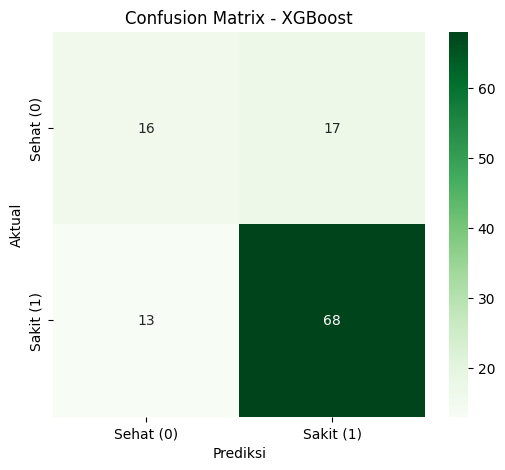

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Inisialisasi Model XGBoost
# use_label_encoder=False untuk menghindari warning di versi baru
# eval_metric='logloss' agar tidak muncul warning default metric
xgb_model = XGBClassifier(
    n_estimators=100,       # Jumlah putaran boosting
    learning_rate=0.1,      # Seberapa cepat model belajar (0.01 - 0.3)
    max_depth=5,            # Kedalaman pohon (makin dalam makin rawan overfitting)
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
)

# 2. Latih Model
xgb_model.fit(X_train_smote, y_train_smote)

# 3. Prediksi
y_pred_xgb = xgb_model.predict(X_test_scaled)

# ---------------- EVALUASI ----------------
print("--- Evaluasi XGBoost ---")
acc = accuracy_score(y_test, y_pred_xgb)
print(f"Akurasi: {acc:.2f} ({acc*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Sehat (0)', 'Sakit (1)']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Sehat (0)', 'Sakit (1)'],
            yticklabels=['Sehat (0)', 'Sakit (1)'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

--- Evaluasi CatBoost ---
Akurasi: 0.70 (70.2%)

Classification Report:
              precision    recall  f1-score   support

   Sehat (0)       0.48      0.39      0.43        33
   Sakit (1)       0.77      0.83      0.80        81

    accuracy                           0.70       114
   macro avg       0.63      0.61      0.62       114
weighted avg       0.69      0.70      0.69       114



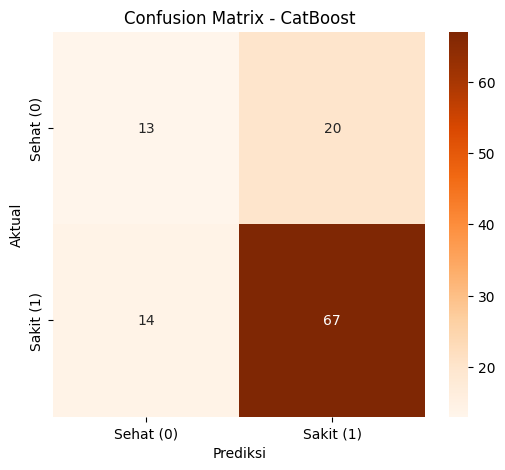

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Inisialisasi Model
# verbose=0 agar log pelatihan tidak memenuhi layar (silent mode)
cb_model = CatBoostClassifier(
    iterations=1000,             # Jumlah pohon (default 1000)
    learning_rate=0.05,          # Kecepatan belajar
    depth=6,                     # Kedalaman pohon (4-10 biasanya optimal)
    loss_function='Logloss',
    auto_class_weights='Balanced', # FITUR KEREN: Otomatis menyeimbangkan data Sakit vs Sehat
    verbose=0,
    random_state=42
)

# 2. Latih Model
# Catatan: Jika kolom 'Gender' Anda masih berupa String (Male/Female), 
# Anda bisa tambahkan parameter: cat_features=['Gender'] di dalam fit()
cb_model.fit(X_train_smote, y_train_smote)

# 3. Prediksi
y_pred_cb = cb_model.predict(X_test_scaled)

# ---------------- EVALUASI ----------------
print("--- Evaluasi CatBoost ---")
acc = accuracy_score(y_test, y_pred_cb)
print(f"Akurasi: {acc:.2f} ({acc*100:.1f}%)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb, target_names=['Sehat (0)', 'Sakit (1)']))

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_cb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Sehat (0)', 'Sakit (1)'],
            yticklabels=['Sehat (0)', 'Sakit (1)'])
plt.title('Confusion Matrix - CatBoost')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()